<a href="https://www.kaggle.com/code/abinashparida123/quora-duplicate?scriptVersionId=166787686" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/test.csv.zip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import os
import tensorflow as tf
import re
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

2024-03-13 07:38:37.206394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 07:38:37.206487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 07:38:37.356905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df=pd.read_csv('/kaggle/input/quora-question-pairs/train.csv.zip')

In [4]:
df.sample(10)

id    qid1    qid2  \
278181  278181   60531  397406   
286953  286953  407625   77450   
207002  207002  310566  310567   
216660  216660  270243  322854   
344999  344999  328437  473288   
215140  215140  210419  320946   
332840  332840  145988   43909   
217533  217533  323906  323907   
274466  274466  393110  393111   
2478      2478    4924    4925   

                                                question1  \
278181  Is The Diabetes Destroyer a scam just like Dia...   
286953  What is the difference between being flirty an...   
207002  How do former Presidents of the United States ...   
216660             Why is the toilet tank not filling up?   
344999         What is the easiest way to become wealthy?   
215140                     How to be less self-conscious?   
332840  How do I find whether my girl friend is cheati...   
217533  Is Hawaii a better destination than Tahiti and...   
274466  What is the relation between OpenStack, OpenDa...   
2478                 Was the White House built by slaves?   

                                                question2  is_duplicate  
278181                        Is diabetes Destroyer scam?             1  
286953  If a girl talks to you on the phone for about ...             0  
207002  Should military service be a prerequisite for ...             0  
216660    Why isn't my toilet tank filling up with water?             1  
344999              How can I become financially wealthy?             1  
215140                    How can be less self-conscious?             1  
332840        How do I know my partner is cheating on me?             1  
217533  Where can you eat on Moorea/Bora Bora where yo...             0  
274466  What is the difference between OpenStack and D...             0  
2478        Was the White House entirely built by slaves?             1

In [5]:
df.shape

(404290, 6)

In [6]:
df.size

2425740

In [7]:
df.describe()

id           qid1           qid2   is_duplicate
count  404290.000000  404290.000000  404290.000000  404290.000000
mean   202144.500000  217243.942418  220955.655337       0.369198
std    116708.614503  157751.700002  159903.182629       0.482588
min         0.000000       1.000000       2.000000       0.000000
25%    101072.250000   74437.500000   74727.000000       0.000000
50%    202144.500000  192182.000000  197052.000000       0.000000
75%    303216.750000  346573.500000  354692.500000       1.000000
max    404289.000000  537932.000000  537933.000000       1.000000

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [9]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [10]:
df['is_duplicate'].isna().sum()

0

In [11]:
df.duplicated().sum()

0

In [12]:
df['is_duplicate'].value_counts()

is_duplicate
0    255027
1    149263
Name: count, dtype: int64

**255027 not duplicated and 149263 are duplicated**

In [13]:
not_duplicate=df['is_duplicate'].value_counts()[0]

In [14]:
duplicate=df['is_duplicate'].value_counts()[1]

In [15]:
total=df['is_duplicate'].count()

In [16]:
percentage_not_duplicate=(not_duplicate/total)*100

In [17]:
percentage_duplicate=(duplicate/total)*100

In [18]:
percentage_not_duplicate,percentage_duplicate

(63.08021469737069, 36.9197853026293)

<Axes: xlabel='is_duplicate'>

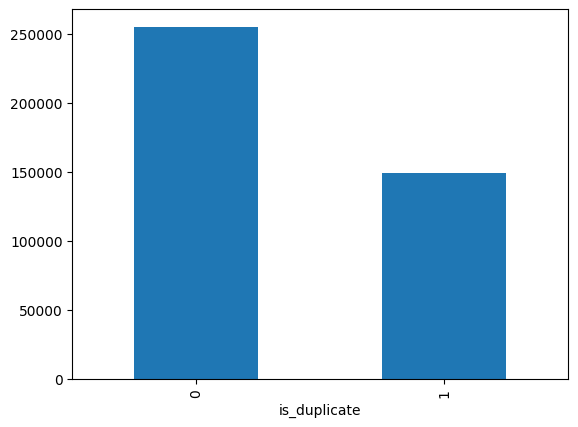

In [19]:
df['is_duplicate'].value_counts().plot(kind='bar')

In [20]:
df['qid1'].nunique()+df['qid2'].nunique() #here if a quention is unique in did1 and qid2 separately then that question is duplicate so we use the below code

590018

In [21]:
qid=pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
np.unique(qid).shape[0]

537933

In [22]:
x=qid.value_counts()>1

In [23]:
x[x].shape[0]

111780

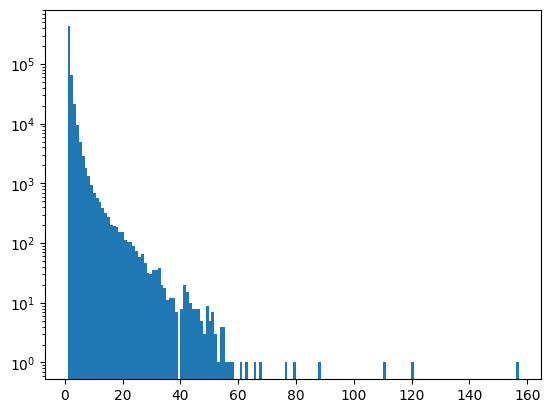

In [24]:
plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')

In [25]:
new_df=df.sample(30000,random_state=2)

In [26]:
que_df=new_df[['question1','question2']]

In [27]:
questions=list(que_df['question1'])+list(que_df['question2'])

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_features=3000)
q1_arr,q2_arr=np.vsplit(cv.fit_transform(questions).toarray(),2)

In [29]:
temp_df1=pd.DataFrame(q1_arr,index=que_df.index)
temp_df2=pd.DataFrame(q2_arr,index=que_df.index)
temp_df=pd.concat([temp_df1,temp_df2],axis=1)

In [30]:
temp_df.shape

(30000, 6000)

In [31]:
temp_df['is_duplicate']=new_df['is_duplicate']

In [32]:
temp_df.sample(5)

0  1  2  3  4  5  6  7  8  9  ...  2991  2992  2993  2994  2995  2996  \
59122   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
352626  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
361073  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
335662  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
365532  0  0  0  0  0  0  0  0  0  0  ...     0     1     0     0     0     0   

        2997  2998  2999  is_duplicate  
59122      0     0     0             0  
352626     0     0     0             0  
361073     0     0     0             0  
335662     0     0     0             1  
365532     0     0     0             0  

[5 rows x 6001 columns]

In [33]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(temp_df.iloc[:,0:-1].values,temp_df.iloc[:,-1],test_size=0.2,random_state=42)

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf_clf=RandomForestClassifier()

In [35]:
rf_clf.fit(X_train,y_train)
y_pred=rf_clf.predict(X_test)

In [36]:
accuracy_score(y_test,y_pred)

0.7396666666666667

In [37]:
new_df['q1_len']=new_df['question1'].str.len()
new_df['q2_len']=new_df['question2'].str.len()

In [38]:
new_df['q1_num_words']=new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words']=new_df['question2'].apply(lambda row: len(row.split(" ")))

In [39]:
def common_words(row):
    #lambda parameter:expression
    w1=set(map(lambda word:word.lower().strip(),row['question1'].split(" ")))
    w2=set(map(lambda word:word.lower().strip(),row['question2'].split(" ")))
    return len(w1 & w2)

In [40]:
new_df['word_common']=new_df.apply(common_words,axis=1)

In [41]:
new_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [42]:
def total_words(row):
    #lambda parameter:expression
    w1=set(map(lambda word:word.lower().strip(),row['question1'].split(" ")))
    w2=set(map(lambda word:word.lower().strip(),row['question2'].split(" ")))
    return len(w1)+len(w2)

In [43]:
new_df['total_words']=new_df.apply(total_words,axis=1)

In [44]:
new_df['word_share']=round(new_df['word_common']/new_df['total_words'],2)

minimum 2
max= 391
mean= 59


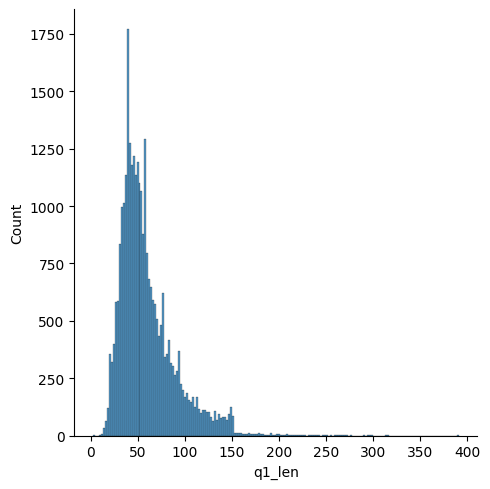

In [45]:
sns.displot(new_df['q1_len'])
print('minimum',new_df['q1_len'].min())
print('max=',new_df['q1_len'].max())
print('mean=',int(new_df['q1_len'].mean()))

minimum 6
max= 1151
mean= 60


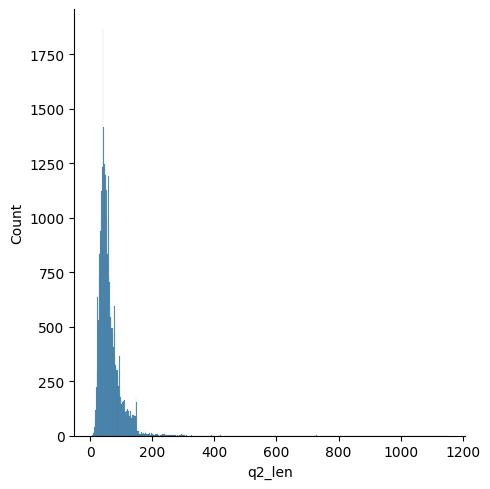

In [46]:
sns.displot(new_df['q2_len'])
print('minimum',new_df['q2_len'].min())
print('max=',new_df['q2_len'].max())
print('mean=',int(new_df['q2_len'].mean()))

minimum 1
max= 72
mean= 10


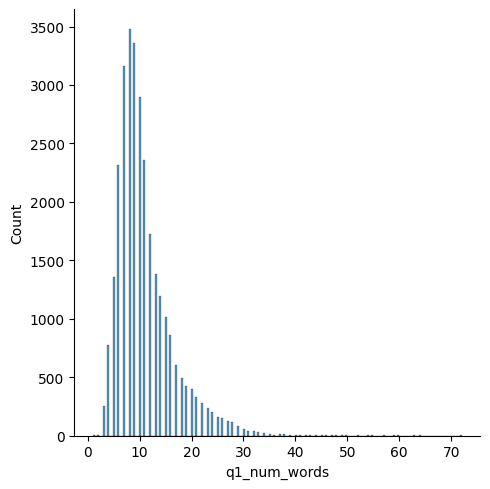

In [47]:
sns.displot(new_df['q1_num_words'])
print('minimum',new_df['q1_num_words'].min())
print('max=',new_df['q1_num_words'].max())
print('mean=',int(new_df['q1_num_words'].mean()))

minimum 1
max= 237
mean= 11


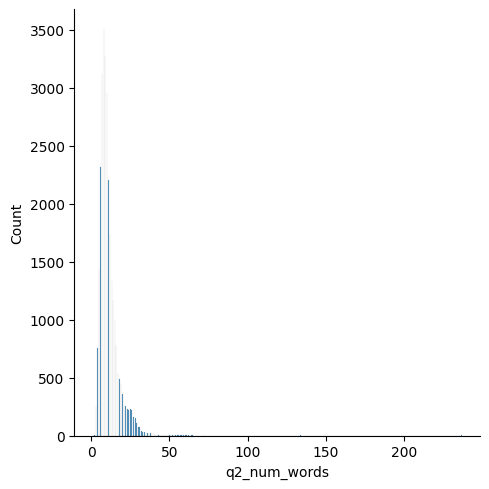

In [48]:
sns.displot(new_df['q2_num_words'])
print('minimum',new_df['q2_num_words'].min())
print('max=',new_df['q2_num_words'].max())
print('mean=',int(new_df['q2_num_words'].mean()))

In [49]:
new_df.replace([np.inf, -np.inf], np.nan, inplace=True)

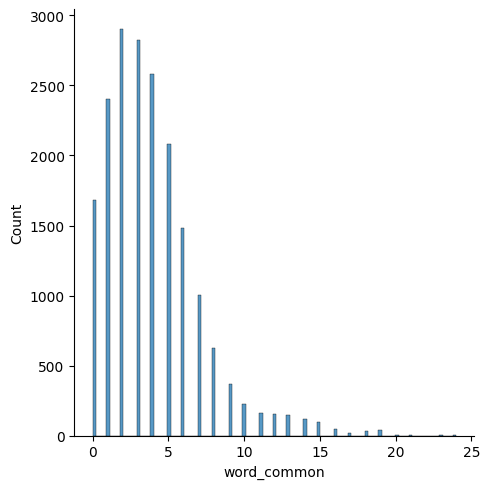

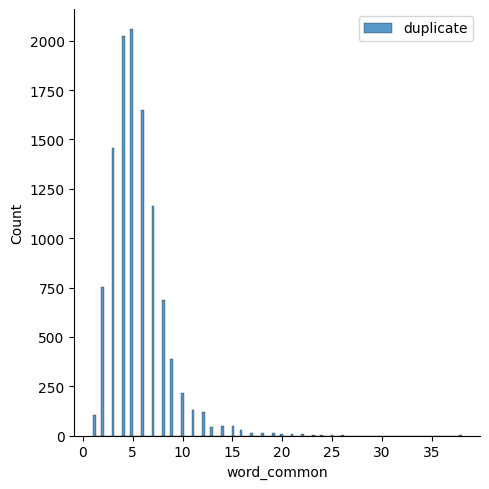

In [50]:
sns.displot(new_df[new_df['is_duplicate']==0]['word_common'],label='non duplicate')
sns.displot(new_df[new_df['is_duplicate']==1]['word_common'],label='duplicate')
plt.legend()
plt.show()

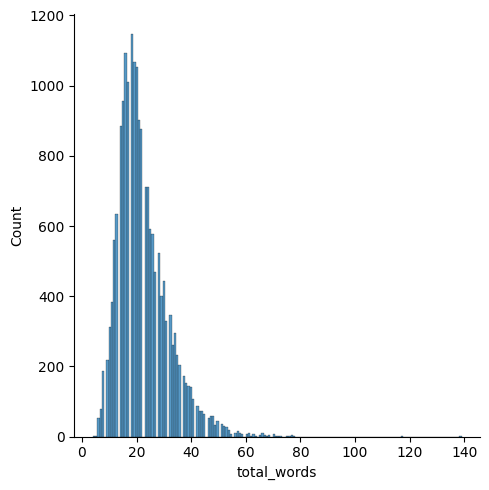

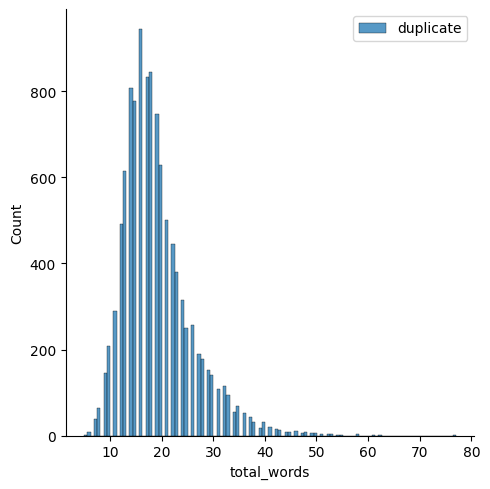

In [51]:
sns.displot(new_df[new_df['is_duplicate']==0]['total_words'],label='non duplicate')
sns.displot(new_df[new_df['is_duplicate']==1]['total_words'],label='duplicate')
plt.legend()
plt.show()

In [52]:
ques_df=new_df[['question1','question2']]
ques_df.head()

question1  \
398782  What is the best marketing automation tool for...   
115086  I am poor but I want to invest. What should I do?   
327711  I am from India and live abroad. I met a guy f...   
367788  Why do so many people in the U.S. hate the sou...   
151235                Consequences of Bhopal gas tragedy?   

                                                question2  
398782  What is the best marketing automation tool for...  
115086  I am quite poor and I want to be very rich. Wh...  
327711  T.I.E.T to Thapar University to Thapar Univers...  
367788  My boyfriend doesnt feel guilty when he hurts ...  
151235  What was the reason behind the Bhopal gas trag...

In [53]:
final_df=new_df.drop(columns=['id','qid1','qid2','question1','question2'])
final_df.shape

(30000, 8)

In [54]:
final_df.head()

is_duplicate  q1_len  q2_len  q1_num_words  q2_num_words  word_common  \
398782             1      76      77            12            12           11   
115086             0      49      57            12            15            7   
327711             0     105     120            25            17            2   
367788             0      59     146            12            30            0   
151235             0      35      50             5             9            3   

        total_words  word_share  
398782           24        0.46  
115086           23        0.30  
327711           34        0.06  
367788           32        0.00  
151235           13        0.23

In [55]:
#bag of words
from sklearn.feature_extraction.text import CountVectorizer
questions=list(ques_df['question1'])+list(ques_df['question2'])
cv=CountVectorizer(max_features=3000)
q11_arr,q22_arr=np.vsplit(cv.fit_transform(questions).toarray(),2)

In [56]:
temp_df11=pd.DataFrame(q11_arr,index=ques_df.index)
temp_df22=pd.DataFrame(q22_arr,index=ques_df.index)
temp_df_0=pd.concat([temp_df1,temp_df2],axis=1)
temp_df_0.shape

(30000, 6000)

In [57]:
final_df=pd.concat([final_df,temp_df_0],axis=1)
final_df.shape

(30000, 6008)

In [58]:
from sklearn.model_selection import train_test_split
X_train1,X_test1,y_train1,y_test1=train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=42)

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf_clf1=RandomForestClassifier()
rf_clf1.fit(X_train1,y_train1)
y_pred1=rf_clf1.predict(X_test1)
accuracy_score(y_test1,y_pred1)

0.763

In [60]:
def text_preprocessing(q):
    #lowercasing
    q=str(q).lower().strip()
    #replace certain special characters with their string equivalent
    q=q.replace('%','percent')
    q=q.replace('$','dollar')
    q=q.replace('@','at')
    q=q.replace('₹','rupee')
    q=q.replace('€','euro') 
    # pattern [math] appears 900 times 
    q=q.replace('[math]','')
    #replacing some numbers with string equivalent
    q=q.replace(',000,000,000','b')
    q=q.replace(',000,000','m')
    q=q.replace(',000','k')
    q=re.sub(r'([0-9]+)000000000',r'\1b',q)
    q=re.sub(r'([0-9]+)000000',r'\1m',q)
    q=re.sub(r'([0-9]+)000',r'\1k',q)
    contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}
    q_decontracted=[]
    for word in q.split():
        if word in contractions:
            word=contractions[word]
        q_decontracted.append(word)
    q=' '.join(q_decontracted)
    q=q.replace("'ve","have")
    q=q.replace("n't","not")
    q=q.replace("'re","are")
    q=q.replace("'ll","will")
    #remove html tags
    q=BeautifulSoup(q)
    q=q.get_text()
    #remove punctuations
    pattern=re.compile('\W')
    q=re.sub(pattern,' ',q).strip()
    return q

In [61]:
new_df['question1']=new_df['question1'].apply(text_preprocessing)
new_df['question2']=new_df['question2'].apply(text_preprocessing)

In [62]:
new_df['q1_len']=new_df['question1'].str.len()
new_df['q2_len']=new_df['question2'].str.len()

In [63]:
new_df['q1_num_words']=new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words']=new_df['question2'].apply(lambda row: len(row.split(" ")))

In [64]:
def total_words(row):
    #lambda parameter:expression
    w1=set(map(lambda word:word.lower().strip(),row['question1'].split(" ")))
    w2=set(map(lambda word:word.lower().strip(),row['question2'].split(" ")))
    return len(w1)+len(w2)

In [65]:
new_df['total_words']=new_df.apply(total_words,axis=1)

In [66]:
def common_words(row):
    #lambda parameter:expression
    w1=set(map(lambda word:word.lower().strip(),row['question1'].split(" ")))
    w2=set(map(lambda word:word.lower().strip(),row['question2'].split(" ")))
    return len(w1 & w2)

In [67]:
new_df['word_common']=new_df.apply(common_words,axis=1)

In [68]:
new_df['word_share']=round(new_df['word_common']/new_df['total_words'],2)

In [69]:
# Advanced Features
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [70]:
token_features = new_df.apply(fetch_token_features, axis=1)

new_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
new_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
new_df["csc_min"]       = list(map(lambda x: x[2], token_features))
new_df["csc_max"]       = list(map(lambda x: x[3], token_features))
new_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
new_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
new_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
new_df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [71]:
pip install distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16258 sha256=491f3f59af1c8db86f5efdfad5c64bd70db764ea7e3ebf961f2dde33bdec0af7
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built distance
Note: you may need to restart the kernel to use updated packages.


In [72]:
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [73]:
length_features = new_df.apply(fetch_length_features, axis=1)

new_df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
new_df['mean_len'] = list(map(lambda x: x[1], length_features))
new_df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [74]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [75]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [76]:
new_df.shape

(30000, 28)

In [77]:
new_df.head()

id    qid1    qid2  \
398782  398782  496695  532029   
115086  115086  187729  187730   
327711  327711  454161  454162   
367788  367788  498109  491396   
151235  151235  237843   50930   

                                                question1  \
398782  what is the best marketing automation tool for...   
115086   i am poor but i want to invest  what should i do   
327711  i am from india and live abroad  i met a guy f...   
367788  why do so many people in the u s  hate the sou...   
151235                 consequences of bhopal gas tragedy   

                                                question2  is_duplicate  \
398782  what is the best marketing automation tool for...             1   
115086  i am quite poor and i want to be very rich  wh...             0   
327711  t i e t to thapar university to thapar univers...             0   
367788  my boyfriend doesnt feel guilty when he hurts ...             0   
151235  what was the reason behind the bhopal gas tragedy             0   

        q1_len  q2_len  q1_num_words  q2_num_words  ...   ctc_max  \
398782      75      76            13            13  ...  0.923070   
115086      48      56            13            16  ...  0.466664   
327711     104     119            28            21  ...  0.115384   
367788      58     145            14            32  ...  0.000000   
151235      34      49             5             9  ...  0.333330   

        last_word_eq  first_word_eq  abs_len_diff  mean_len  \
398782           1.0            1.0           0.0      13.0   
115086           1.0            1.0           3.0      13.5   
327711           0.0            0.0           6.0      23.0   
367788           0.0            0.0          17.0      21.5   
151235           1.0            0.0           4.0       7.0   

        longest_substr_ratio  fuzz_ratio  fuzz_partial_ratio  \
398782              0.855263          99                  99   
115086              0.224490          69                  67   
327711              0.047619          42                  42   
367788              0.050847          37                  50   
151235              0.542857          60                  71   

        token_sort_ratio  token_set_ratio  
398782                99               99  
115086                67               74  
327711                39               46  
367788                38               40  
151235                48               69  

[5 rows x 28 columns]

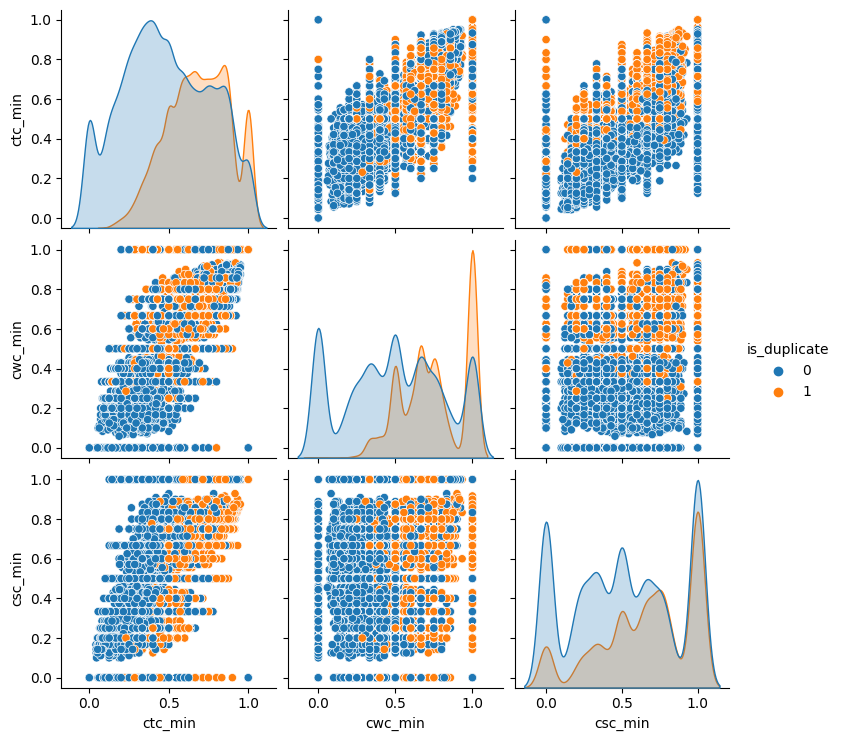

In [78]:
sns.pairplot(new_df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

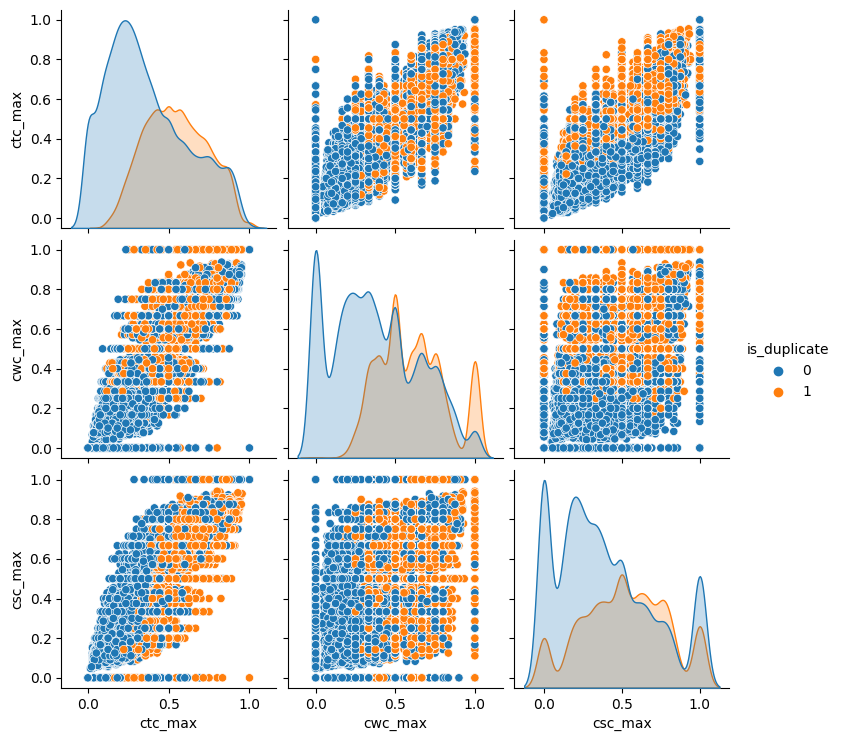

In [79]:
sns.pairplot(new_df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

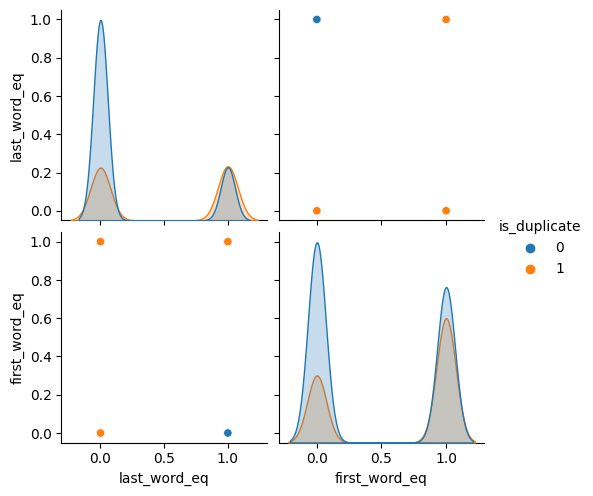

In [80]:
sns.pairplot(new_df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

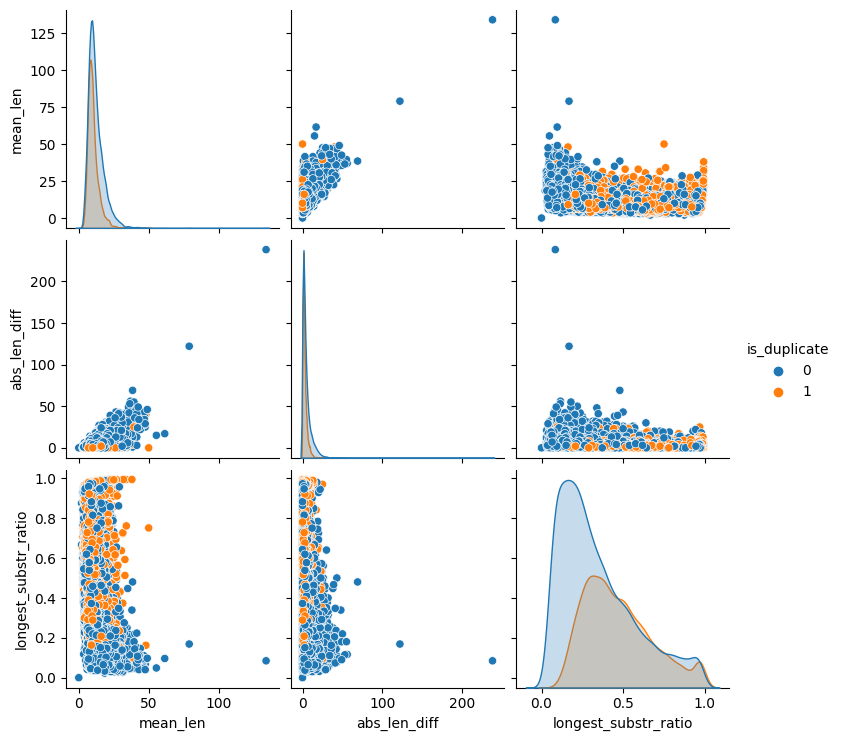

In [81]:
sns.pairplot(new_df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

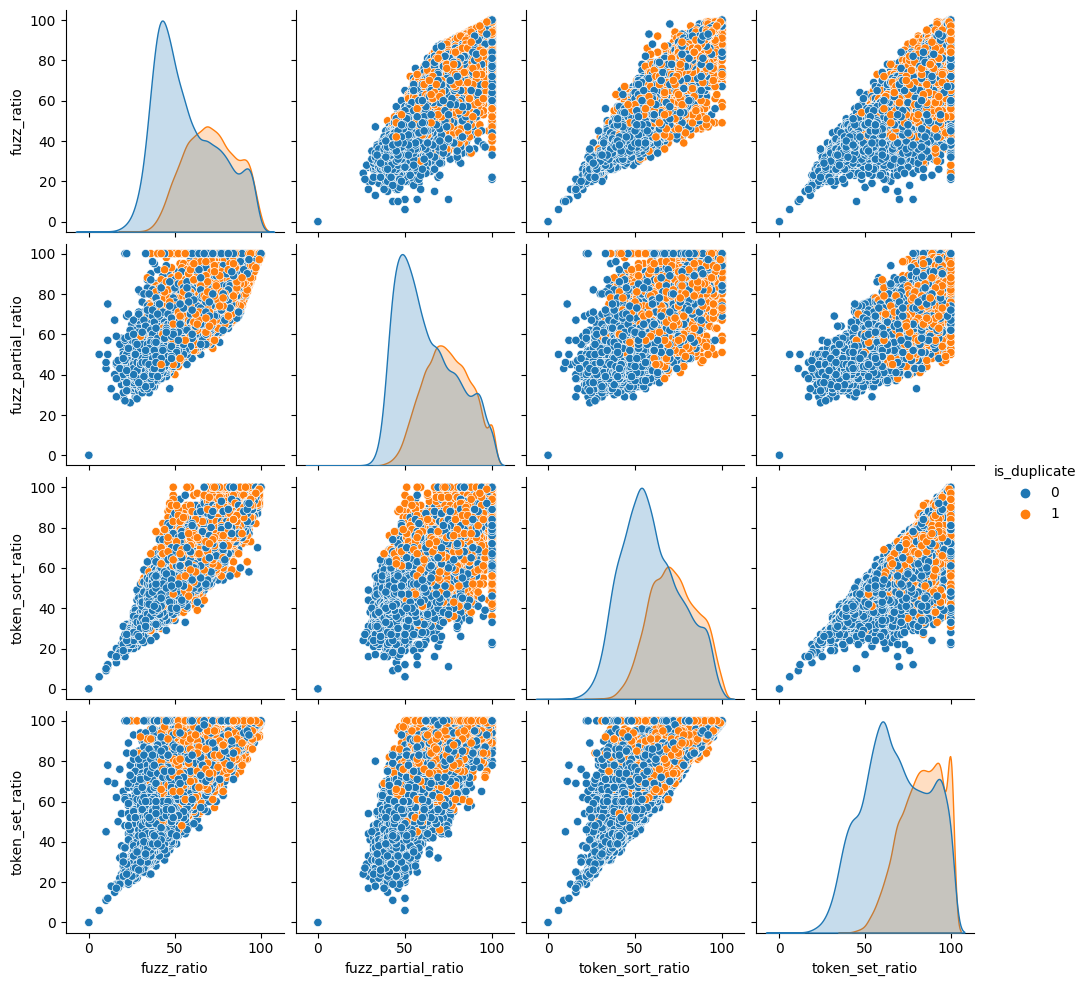

In [82]:
sns.pairplot(new_df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [83]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(new_df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = new_df['is_duplicate'].values

In [84]:
from sklearn.manifold import TSNE

tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.046s...
[t-SNE] Computed neighbors for 30000 samples in 4.195s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sam

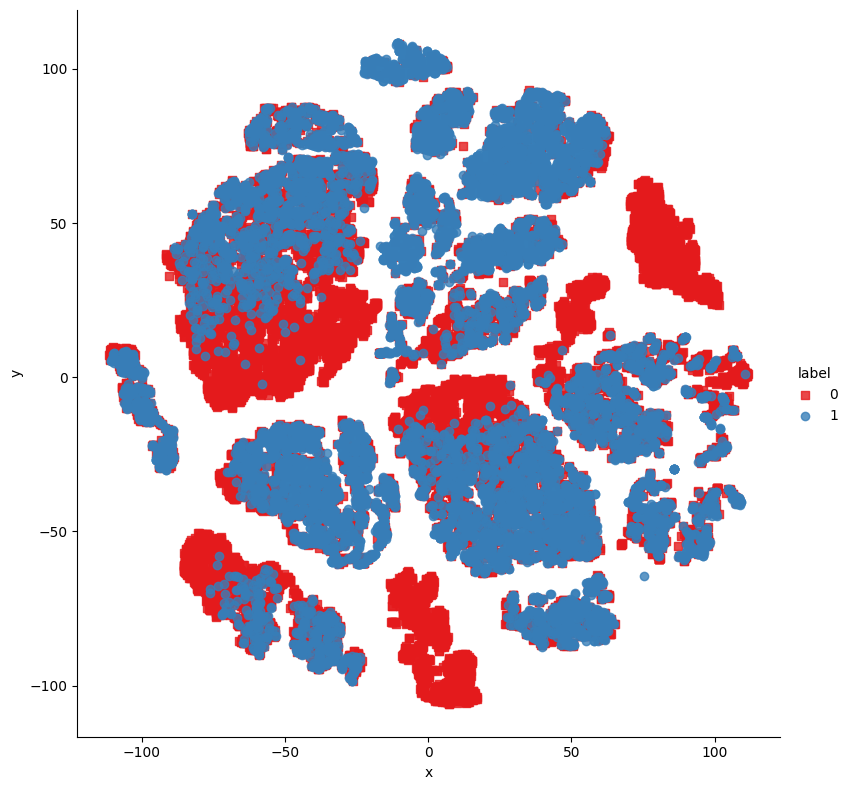

In [85]:
x_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=x_df, x='x', y='y', hue='label', fit_reg=False, height=8,palette="Set1",markers=['s','o'])

In [86]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.047s...
[t-SNE] Computed neighbors for 30000 samples in 4.147s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sam

In [87]:
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.offline as py
py.init_notebook_mode(connected=True)

trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

In [88]:
ques_df = new_df[['question1','question2']]
ques_df.head()

question1  \
398782  what is the best marketing automation tool for...   
115086   i am poor but i want to invest  what should i do   
327711  i am from india and live abroad  i met a guy f...   
367788  why do so many people in the u s  hate the sou...   
151235                 consequences of bhopal gas tragedy   

                                                question2  
398782  what is the best marketing automation tool for...  
115086  i am quite poor and i want to be very rich  wh...  
327711  t i e t to thapar university to thapar univers...  
367788  my boyfriend doesnt feel guilty when he hurts ...  
151235  what was the reason behind the bhopal gas tragedy

In [89]:
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(30000, 23)


is_duplicate  q1_len  q2_len  q1_num_words  q2_num_words  word_common  \
398782             1      75      76            13            13           12   
115086             0      48      56            13            16            8   
327711             0     104     119            28            21            4   
367788             0      58     145            14            32            1   
151235             0      34      49             5             9            3   

        total_words  word_share   cwc_min   cwc_max  ...   ctc_max  \
398782           26        0.46  0.874989  0.874989  ...  0.923070   
115086           24        0.33  0.666644  0.499988  ...  0.466664   
327711           38        0.11  0.000000  0.000000  ...  0.115384   
367788           34        0.03  0.000000  0.000000  ...  0.000000   
151235           13        0.23  0.749981  0.599988  ...  0.333330   

        last_word_eq  first_word_eq  abs_len_diff  mean_len  \
398782           1.0            1.0           0.0      13.0   
115086           1.0            1.0           3.0      13.5   
327711           0.0            0.0           6.0      23.0   
367788           0.0            0.0          17.0      21.5   
151235           1.0            0.0           4.0       7.0   

        longest_substr_ratio  fuzz_ratio  fuzz_partial_ratio  \
398782              0.855263          99                  99   
115086              0.224490          69                  67   
327711              0.047619          42                  42   
367788              0.050847          37                  50   
151235              0.542857          60                  71   

        token_sort_ratio  token_set_ratio  
398782                99               99  
115086                67               74  
327711                39               46  
367788                38               40  
151235                48               69  

[5 rows x 23 columns]

In [90]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [91]:
temp_df111 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df222 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df_00 = pd.concat([temp_df1, temp_df2], axis=1)
temp_df_00.shape

(30000, 6000)

In [92]:
final_df = pd.concat([final_df, temp_df_00], axis=1)
print(final_df.shape)
final_df.head()

(30000, 6023)


is_duplicate  q1_len  q2_len  q1_num_words  q2_num_words  word_common  \
398782             1      75      76            13            13           12   
115086             0      48      56            13            16            8   
327711             0     104     119            28            21            4   
367788             0      58     145            14            32            1   
151235             0      34      49             5             9            3   

        total_words  word_share   cwc_min   cwc_max  ...  2990  2991  2992  \
398782           26        0.46  0.874989  0.874989  ...     0     0     0   
115086           24        0.33  0.666644  0.499988  ...     0     0     0   
327711           38        0.11  0.000000  0.000000  ...     0     0     0   
367788           34        0.03  0.000000  0.000000  ...     0     0     0   
151235           13        0.23  0.749981  0.599988  ...     0     0     0   

        2993  2994  2995  2996  2997  2998  2999  
398782     0     0     0     0     0     0     0  
115086     0     0     0     0     0     0     0  
327711     0     0     0     0     0     0     0  
367788     1     0     0     0     0     0     0  
151235     0     0     0     0     0     0     0  

[5 rows x 6023 columns]

In [93]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.789